<a href="https://colab.research.google.com/github/KubaSiwiec/hsi_spatial_spectral/blob/collab/hsi_learn_lbp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
'''
feature extraction functions
'''

import scipy.io
from skimage.util import view_as_windows
from skimage.util import pad
import numpy as np


def get_data(file_name):
    return scipy.io.loadmat(file_name)

def get_patches(image, size = 3, use_padding = 'SAME'):

    # add padding for image to make it able to extract the number of patches equal to number of pixels
    # the pad width should eqal (patch size - 1) / 2,  - center pixel will always lay in original image
    nb_padding_pixels = int(size/2 - 0.5)
    # choose symmetric mode
    image_padded = pad(image, nb_padding_pixels, 'symmetric')

    patch_size = (size, size, image.shape[2])
    patches = view_as_windows(image_padded, patch_size)[:, :, 0]
    return patches

def grey_to_lbp(image):

    image_shape = image.shape
    image_width = image_shape[0]
    image_height = image_shape[1]
    image_depth = image_shape[2]

    # print("Shape: {}, Width: {}, Height: {}, Depth: {}".format(image_shape, image_width, image_height, image_depth))

    #get the image shape
    central_pixel = image[int((image_width - 1) / 2), int((image_height - 1) / 2), :]

    # print("Central pixel: {}".format(central_pixel))

    lbp_map = np.zeros(image.shape)
    # dimensions of the image: (image_width,image_height,image_depth)
    # for each of k channels
    for k in range(image_depth):
        # compare each pixel greyscale value with the central pixel
        for i in range(image_width):
            for j in range(image_height):
                if image[i,j,k] >= central_pixel[k]:
                    lbp_map[i,j,k] = 1
                elif image[i,j,k] < central_pixel[k]:
                    lbp_map[i,j,k] = 0
                # setting the central pixel to 0.5 removes the noisy pixel from the middle of a image
                #but LBP map stops to be binary
                #when using it, remove the eqaul sign from the first conditional equation
                # else:
                #     lbp_map[i,j,k] = 0.5

    print('lbp map: {}'.format(lbp_map))

    return lbp_map


def grey_to_clbp(image):
    #here, the treshold will be set as mean of the image, not as value of specific central pixel

    image_shape = image.shape
    image_width = image_shape[0]
    image_height = image_shape[1]
    image_depth = image_shape[2]

    # print("Shape: {}, Width: {}, Height: {}, Depth: {}".format(image_shape, image_width, image_height, image_depth))

    #get the image shape
    central_pixel = image[int((image_width - 1) / 2), int((image_height - 1) / 2), :]

    # print("Central pixel: {}".format(central_pixel))

    clbp_map = np.zeros(image.shape)
    # dimensions of the image: (image_width,image_height,image_depth)
    # for each of k channels
    for k in range(image_depth):
        # compare each pixel greyscale value with the mean of the image

        #get mean of a layer
        channel_mean = np.mean(image[:, :, k])
        for i in range(image_width):
            for j in range(image_height):
                if image[i,j,k] >= channel_mean:
                    clbp_map[i,j,k] = 1
                elif image[i,j,k] < channel_mean:
                    clbp_map[i,j,k] = 0

    return clbp_map





def hs_to_grey(image):
    return np.mean(image, axis = 2)

def arr2D_to_list(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 2:
        print('Gt width: {}, length: {}'.format(arr.shape[0], arr.shape[1]))
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                lst.append(arr[i, j])

        return lst
    else:
        raise Exception('Array should be two dimentional')

def arr5D_to_list_of_3D_arr(arr: np.array):
    dims = len(arr.shape)
    lst = []
    if dims == 5:
        for i in range(arr.shape[0]):
            for j in range(arr.shape[1]):
                    lst.append(arr[i, j])
        return lst
    else:
        raise Exception('Array should be two dimentional')





In [0]:
'''
F1-score metric
'''

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
'''
create model function
'''
from tensorflow import keras

# model definition function
def create_model(l2_loss_lambda = None):
    keras.backend.clear_session()

    target_size = (32, 32)
    l2 = None if l2_loss_lambda is None else keras.regularizers.l2(l2_loss_lambda)
    if l2 is not None:
        print('Using L2 regularization - l2_loss_lambda = %.4f' % l2_loss_lambda)

    model = keras.Sequential(
        [
            keras.layers.Lambda(lambda image: tf.image.resize(image, target_size)),
            keras.layers.Conv2D(256, 3, activation=tf.nn.relu, input_shape=(32, 32, 103)),
            keras.layers.MaxPool2D(2),
            keras.layers.Conv2D(512, 3, activation=tf.nn.relu),
            keras.layers.MaxPool2D(2),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation=tf.nn.relu, kernel_regularizer=l2),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )

    # model compiling

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", f1_m]
    )

    return model

In [0]:
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import matplotlib.pyplot as plt

In [28]:
mat = get_data("/content/drive/My Drive/PaviaU.mat")
# print(mat)

mat_gt = get_data("/content/drive/My Drive/PaviaU_gt.mat")
# print(mat_gt

data = mat['paviaU']
ground_truth = mat_gt['paviaU_gt']

print("Shape of the cube: {}".format(data.shape))
print("Shape of the labels_arr: {}".format(ground_truth.shape))
print("Number of classes: {}".format(np.unique(ground_truth)))

print("Maximum value: {}".format(np.argmax(data)))

print("Index of maximum value: {}".format(np.unravel_index(np.argmax(data), data.shape)))


# print(get_data._hs_to_grey(data_patches_hsi[8,5,0]))










Shape of the cube: (610, 340, 103)
Shape of the labels_arr: (610, 340)
Number of classes: [0 1 2 3 4 5 6 7 8 9]
Maximum value: 396299
Index of maximum value: (11, 107, 58)


In [29]:
# apply lbp and clbp on image
lbp_image = grey_to_lbp(data)
print('LBP image shape: {}'.format(lbp_image.shape))
# clbp_image = hsi_preprocessing.grey_to_clbp(data)







lbp map: [[[0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 0. ... 1. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 0. ... 0. 0. 0.]]

 [[1. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]
  ...
  [1. 1. 0. ... 1. 1. 1.]
  [0. 0. 0. ... 1. 1. 1.]
  [1. 0. 0. ... 1. 1. 1.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [1. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [1. 1. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[1. 1. 1. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  [1. 1. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 1. 0. ... 0. 0. 0.]
  [1. 1. 0. ... 0. 0. 0.]]]
L

In [30]:
#crop patches
patch_size = 5
data_patches_lbp = get_patches(lbp_image, patch_size)
print('LBP patches shape: {}'.format(data_patches_lbp.shape))
# data_patches_clbp = hsi_preprocessing.get_patches(clbp_image, 3)

LBP patches shape: (610, 340, 5, 5, 103)


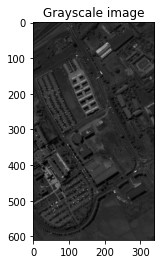

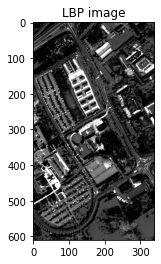

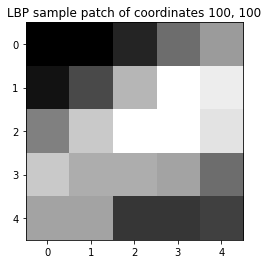

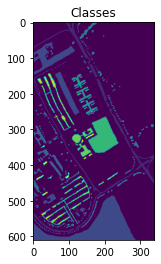

In [33]:
'''
Plotting images
'''

#compare greyscale image with lbp map
plt.figure(1)
plt.imshow(hs_to_grey(data), cmap='gray')
plt.title("Grayscale image")

plt.figure(2)
plt.imshow(hs_to_grey(lbp_image), cmap='gray')
plt.title("LBP image")

# plt.figure(3)
# plt.imshow(hs_to_grey(clbp_image), cmap='gray')
# plt.title("CLBP image")

# present some patches of lbp data
plt.figure(4)
co_x = 100
co_y = 100
plt.imshow(hs_to_grey(data_patches_lbp[co_x, co_y]), cmap='gray')
plt.title("LBP sample patch of coordinates {}, {}".format(co_x, co_y))

# # present some patches of lbp data
# plt.figure(5)
# co_x = 11
# co_y = 107
# plt.imshow(hs_to_grey(data_patches_clbp[co_x, co_y, 0]), cmap='gray')
# plt.title("LBP sample patch of coordinates {}, {}".format(co_x, co_y))

plt.figure(6)
plt.imshow(ground_truth)
plt.title('Classes')

plt.show()











In [34]:
'''
Save patches and ground truth into arrays
'''

# patches
patch_lbp_arr = np.asarray(arr5D_to_list_of_3D_arr(data_patches_lbp))
print('patch_lbp_list len: {}'.format(len(patch_lbp_arr)))

# ground truth
labels_gt = np.asarray(arr2D_to_list(ground_truth))
print("Labels len: {}".format(len(labels_gt)))
print(np.unique(labels_gt))

# free memory
lbp_image = None
data_patches_lbp = None

patch_lbp_list len: 207400
Gt width: 610, length: 340
Labels len: 207400
[0 1 2 3 4 5 6 7 8 9]


In [0]:
'''
split data to training and validation datasets
'''

val_split = 0.25
X_train, X_val, y_train, y_val = train_test_split(patch_lbp_arr, labels_gt, test_size=val_split, stratify=labels_gt)

#free memory
patch_lbp_arr = None
label_gt = None

In [0]:
'''
Create and fit model, get loss, accuracy and f1-score metrics
'''
model = create_model(None)

history = model.fit(X_train, y_train, batch_size = 256, epochs=30, validation_data=(X_val, y_val))
print(model.summary())

Epoch 1/30
398/608 [==================>...........] - ETA: 36s - loss: 0.6254 - accuracy: 0.8015 - f1_m: 0.6190

In [0]:
'''
Plot accuracy
'''

plt.figure(1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train accuracy', 'val accuracy'])
plt.title("LBP, CNN, {}x{} patch".format(patch_size, patch_size))
plt.show()

In [0]:
'''
get predictions and predicted labels
'''

predictions = model.predict(X_val)
gt_predicted = [np.argmax(prediction) for prediction in predictions]


In [0]:
'''
Calculate kappa coefictient
'''

from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_val, np.array(gt_predicted))
print(kappa)